In [11]:
from funcs.notebook import *
from funcs.detrend import custom_detrending, estimate_detrended_noise, measure_flare
from altaipony.lcio import from_mast

from altaipony.altai import equivalent_duration, find_iterative_median
from altaipony.flarelc import FlareLightCurve

import time
from bokeh.plotting import figure, output_notebook, show



/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [15]:
def wrap_detrend(flc):
    flcd = custom_detrending(flc)
    # define two hour window for rolling std
    w = np.floor(1./12./np.nanmin(np.diff(flcd.time)))
    if w%2==0: 
        w+=1

    # use window to estimate the noise in the LC
    flcd = estimate_detrended_noise(flcd, std_window=int(w), mask_pos_outliers_sigma=1.5)
    return flcd

In [146]:
df = pd.read_csv("../results/2021_02_18_AUMic_flares_1.csv")

In [147]:
df.ampl_rec.median()

0.0014180759530115

In [5]:
df_ = df[(~df.note.isnull()) & (df["real?"]==1)]
df_.shape

NumExpr defaulting to 8 threads.


(16, 19)

In [148]:
flc = from_mast("AU Mic", mission="TESS", c=1, cadence="short",
                download_dir="/home/ekaterina/Documents/001_science/lcs")

Found cached file /home/ekaterina/Documents/001_science/lcs/mastDownload/TESS/tess2018206045859-s0001-0000000441420236-0120-s/tess2018206045859-s0001-0000000441420236-0120-s_lc.fits with expected size 2039040.
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-1.0.0-py3.6.egg/altaipony/lcio.py:114: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/Documents/001_science/lcs/mastDownload/TESS/tess2018206045859-s0001-0000000441420236-0120-s/tess2018206045859-s0001-0000000441420236-0120-s_lc.fits' mode='rb' closefd=True>
  c)


In [20]:
flc = flc[0]

In [18]:
flcd = custom_detrending(flc)

AttributeError: 'list' object has no attribute 'time'

In [19]:
# define two hour window for rolling std
w = np.floor(1./12./np.nanmin(np.diff(flcd.time)))
if w%2==0: 
    w+=1

# use window to estimate the noise in the LC
flcd = estimate_detrended_noise(flcd, std_window=int(w), mask_pos_outliers_sigma=1.5)

NameError: name 'flcd' is not defined

In [144]:
row = df.iloc[15]
sta, sto = row.istart, row.istop
row

istart                                      6262
istop                                       6294
cstart                                   3500383
cstop                                    3500415
tstart                                   2037.73
tstop                                    2037.74
ed_rec                                  0.854447
ed_rec_err                             0.0359711
ampl_rec                              0.00296676
dur                                   0.00740762
total_n_valid_data_points                 100736
ID                                        AU Mic
qcs                                           27
mission                                     TESS
tstamp                       11_02_2021_08_59_15
dur_detrend                              66.3829
lc_n                                           0
real?                                          0
note                                         NaN
final                                          0
Name: 15, dtype: obj

In [145]:

# output to jupyter notebook
output_notebook()


if flc.time_format == "bkjd":
    xlabel = "Time - 2454833 [BKJD days]"
elif flc.time_format == "btjd":
    xlabel = "Time - 2457000 [BTJD days]"
elif flc.time_format == "jd":
    xlabel = "Time [JD]"
else:
    xlabel = "Time"

# create a new plot with a title and axis labels
p = figure(title=str(flc.targetid),
           x_axis_label=xlabel,
           y_axis_label=r'flux',
           tools="reset,box_zoom,pan,tap",
           frame_width=800, frame_height=300)


# add a line renderer with legend and line thickness
p.line(flc.time, flc.flux, line_width=2, line_color="black")

p.scatter(flc.time[sta:sto], flc.flux[sta:sto], line_width=2, fill_color="red", line_color="red")

# show the results
show(p, notebook_handle=True);

Loading BokehJS ...

In [147]:
# de/trend
# pick sta and sto
# get and append pd.Series to flares
sta, sto = row.istart, row.istop+15

In [149]:
flcd.flares = flc.flares
flcd.flares

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,total_n_valid_data_points,dur


In [150]:
measure_flare(flcd, sta, sto)

In [151]:
flcd.flares["total_n_valid_data_points"] = row.total_n_valid_data_points
flcd.flares["ID"] = row.ID
flcd.flares["qcs"] = row.qcs
flcd.flares["mission"] = row.mission
flcd.flares["tstamp"] = time.strftime("%d_%m_%Y_%H_%M_%S", time.localtime())
flcd.flares["dur_detrend"] = row.dur_detrend
flcd.flares["lc_n"] = row.lc_n


flcd.flares = flcd.flares[['istart', 'istop', 'cstart', 'cstop', 'tstart', 'tstop', 'ed_rec',
       'ed_rec_err', 'ampl_rec', 'dur', 'total_n_valid_data_points',  'ID',
       'qcs', 'mission', 'tstamp', 'dur_detrend', 'lc_n']]

# add results to file
with open("../results/2021_02_18_AUMic_flares_1.csv", "a") as file:
    flcd.flares.to_csv(file, index=False, header=False)

In [ ]:
time = np.arange(10, 10 + 10 * np.pi,.0008)

errorval = 2.
mean = 200.
# define the flux
flux = (np.random.normal(0,errorval,time.shape[0]) +
        mean )

# add a gap in the data
flux[5600:7720] = np.nan

# add big and long flare
l = 66
sta = 5280
sto = sta + l
flux[sta:sto] = flux[sta:sto] + np.linspace(1000,0,l)

err = np.full_like(time,errorval)

# define FLC
flc = FlareLightCurve(time=time, detrended_flux=flux, detrended_flux_err=err)

flc = find_iterative_median(flc)

ed, ederr = equivalent_duration(flc, 5280, 5280+l, err =True)
ed, ederr

dt = (time[1]-time[0]) * 24 * 60 * 60

edref = dt * (sto - sta +1) * ((1200 - 200)/2 ) / 200 

In [ ]:
dd = df_[df_.note=="gradual like a spot"]
diffs = np.diff(dd.tstart)
diffs

In [ ]:
plt.hist(diffs, bins=40);

In [ ]:
np.max(diffs)

In [ ]:
diffs.shape

In [149]:
flc.flares = df[(df.final==1) & (df["real?"]==1)]
flc.flares

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points,ID,qcs,mission,tstamp,dur_detrend,lc_n,real?,note,final
6,1509,1519,71983,71993,1327.437532,1327.451421,0.661332,0.038413,0.001381,0.013889,18094,AU Mic,1,TESS,18_02_2021_14_40_23,8.047532,0,1.0,NaN,1.0
7,1532,1539,72006,72013,1327.469477,1327.479199,0.659758,0.044819,0.001441,0.009722,18094,AU Mic,1,TESS,18_02_2021_14_40_23,8.047532,0,1.0,NaN,1.0
8,1818,1827,72313,72322,1327.895864,1327.908364,1.669144,0.039894,0.003435,0.012500,18094,AU Mic,1,TESS,18_02_2021_14_40_23,8.047532,0,1.0,NaN,1.0
9,1997,2004,72492,72499,1328.144475,1328.154197,0.923981,0.045494,0.002392,0.009722,18094,AU Mic,1,TESS,18_02_2021_14_40_23,8.047532,0,1.0,NaN,1.0
11,2254,2278,72751,72775,1328.504196,1328.537529,14.728960,0.035002,0.025630,0.033333,18094,AU Mic,1,TESS,18_02_2021_14_40_23,8.047532,0,1.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,10446,10461,82015,82030,1341.370714,1341.391547,0.801417,0.042095,0.001267,0.020833,18094,AU Mic,1,TESS,18_02_2021_17_05_35,8.047532,0,1.0,gradual flare,1.0
120,10871,10891,82452,82472,1341.977643,1342.005420,0.821241,0.034584,0.001806,0.027777,18094,AU Mic,1,TESS,18_02_2021_17_07_05,8.047532,0,1.0,long tail,1.0
121,13163,13177,84782,84796,1345.213665,1345.233109,0.823544,0.064425,0.000785,0.019444,18094,AU Mic,1,TESS,18_02_2021_17_08_34,8.047532,0,1.0,gradual flare,1.0
122,13375,13456,84994,85075,1345.508101,1345.620598,12.870926,0.034926,0.006680,0.112497,18094,AU Mic,1,TESS,18_02_2021_17_10_50,8.047532,0,1.0,long tail,1.0


In [132]:
fff = flc.flares[ (flc.flares["real?"]==1) &
                 (flc.flares.final==1) &
                 (flc.flares.dur>1e-3) &
                 (flc.flares.ampl_rec>6e-3)]
fff.shape

(23, 38)

In [97]:
fff.recovery_probability = fff.recovery_probability.fillna(1)
f4 = fff[(fff.recovery_probability > 0.2) & (fff["real?"]==1) & (fff.final==1)]

In [98]:
f4.ed_ratio = f4.ed_ratio.fillna(1.)
f4.ed_rec = f4.ed_rec / f4.ed_ratio

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [151]:
from altaipony.ffd import FFD
simple_ffd = FFD(f=flc.flares, tot_obs_time=(flc.flares.total_n_valid_data_points/60/24*2).iloc[0])
simple_ffd.tot_obs_time

25.130555555555556

In [152]:
with open("../results/values/tesslum_aumic.txt", "r") as f:
    tesslum = float(f.readline())

Setting ED with new values, size 75.
Setting frequency values with new values, size 75.
Setting frequency adjusted count values with new values, size 75.


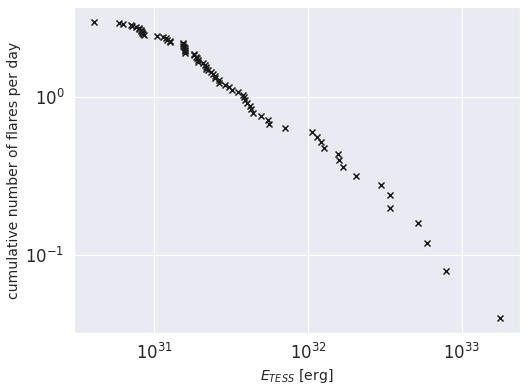

In [153]:
%matplotlib inline
ed, freq, counts = simple_ffd.ed_and_freq()
plt.figure(figsize=(8, 6))
plt.scatter(ed*tesslum, freq, c="k", marker="x")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$E_{TESS}$ [erg]", fontsize=14)
plt.ylabel("cumulative number of flares per day", fontsize=14);

In [154]:
BFA = simple_ffd.fit_powerlaw("mcmc")

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [00:05<00:00, 86.33it/s]


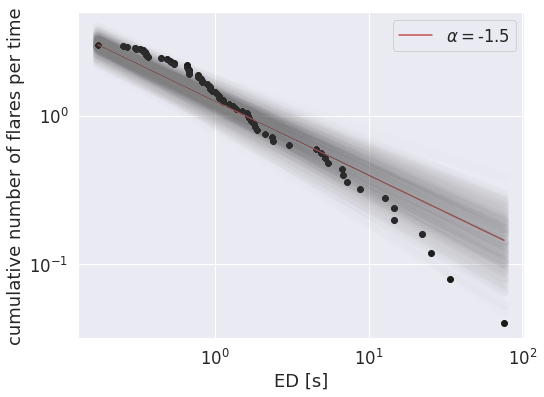

In [155]:


fig, ax = plt.subplots(1, figsize=(8,6))
ax.scatter(ed, freq, c="k")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("ED [s]")
ax.set_ylabel("cumulative number of flares per time")
simple_ffd.plot_powerlaw(ax, c="r", label=fr'$\alpha=$-{simple_ffd.alpha:.1f}')
simple_ffd.plot_mcmc_powerlaw(ax, BFA, subset=300)
plt.legend();



In [156]:
simple_ffd.alpha_up_err, simple_ffd.alpha_low_err

(0.05910677509204443, 0.05578256453955843)

In [ ]:
flcd.fake_flares = flcd.flares
flcd.fake_flares

In [ ]:
flc, fake_flc = flcd.sample_flare_recovery(inject_before_detrending=False, mode="custom", func=wrap_detrend,
                                          iterations=15, fakefreq=1, ampl=[0.001, 0.05],
                                          dur=[5e-4, 1e-3])

In [ ]:
flc.fake_flares

In [ ]:
# add results to file
with open("../results/2021_02_AUMic_27_fakeflares.csv", "a") as file:
    flc.fake_flares.to_csv(file, index=False, header=False)

In [37]:
flc.fake_flares = pd.read_csv("../results/2021_02_AUMic_27_fakeflares.csv").drop_duplicates()
flc.fake_flares.shape

(8372, 15)

In [5]:
flc.fake_flares = flc.fake_flares[(flc.fake_flares.duration_d < 0.02) & (flc.fake_flares.amplitude < 0.2)]

NumExpr defaulting to 8 threads.


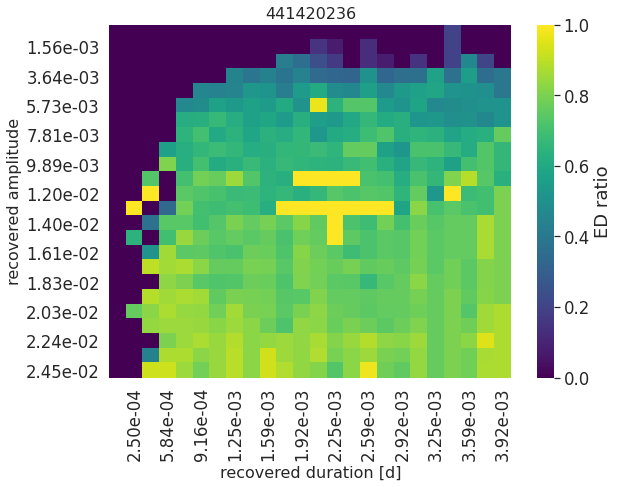

In [70]:
%matplotlib inline
fig = flc.plot_ed_ratio_heatmap(ampl_bins=np.linspace(0,.025,25), dur_bins=np.linspace(0,.004,25),interpolate=True)

Text(0.5, 1.0, '')

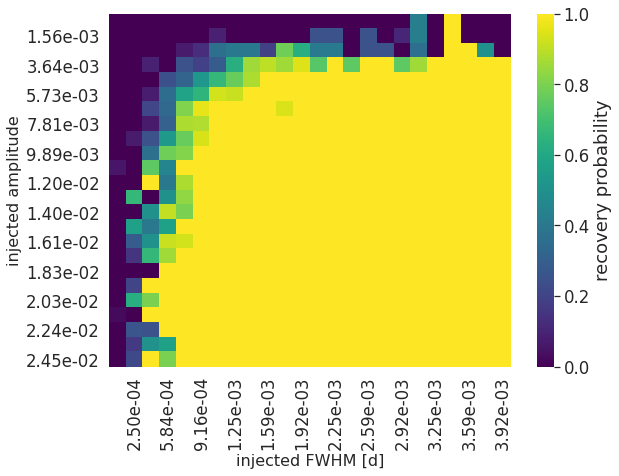

In [69]:
fig = flc.plot_recovery_probability_heatmap(ampl_bins=np.linspace(0,.025,25), dur_bins=np.linspace(0,.004,25),interpolate=True)
plt.title(None)

In [40]:
flc.flares=df

In [71]:
flc = flc.characterize_flares(ampl_bins=np.linspace(0,.025,25), dur_bins=np.linspace(0,.004,25))

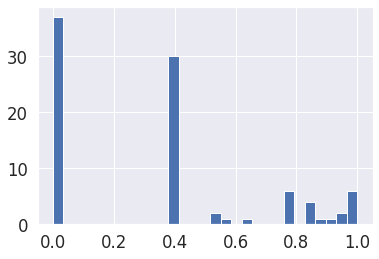

In [72]:
flc.flares.recovery_probability.dropna().hist(bins=np.linspace(0,1,30))

In [73]:
flc.flares.to_csv("../results/2021_02_AuMic_27_characterized.csv",index=False)

In [ ]:
flc.flares.ed_ratio.dropna().hist(bins=np.linspace(0,1,30))

In [ ]:
plt.scatter(flc.flares.dur, flc.flares.duration_corr)
plt.plot([0,1e-2],[0,1e-2])

In [ ]:
flc.flares.shape, flc.flares.ed_ratio.dropna().shape

In [ ]:
_ = pd.read_csv("../results/2021_02_11_AUMic_flares_27.csv")
df = _[(_["real?"]==1) & (_["final"]==1)]
df.shape, _.shape

In [ ]:
df.ampl_rec.hist(bins=np.logspace(-4,-2,20))
plt.xscale("log")

In [ ]:
df.dur.hist(bins=np.logspace(-3.6,-.4,10))
plt.xscale("log")

In [ ]:
2.5e-3 * 24 * 60

In [ ]:
from altaipony.injrecanalysis import tile_up_injection_recovery

In [ ]:
df, val = tile_up_injection_recovery(flc.fake_flares, "ed_ratio", ampl_bins=np.linspace(0,.04,18), dur_bins=np.linspace(0,.005,21))

In [ ]:
df

In [ ]:
df = df.reset_index()
df.Amplitude = df.Amplitude.apply(lambda x: x.mid)
df.Duration = df.Duration.apply(lambda x: x.mid)

# Init figure
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (9,7))


# Create heatmap data format 
heatmap1_data = pd.pivot_table(df, values=val, 
                     index=['Amplitude'], 
                     columns=['Duration'])

heatmap1_data

In [ ]:
heatmap1_data= (heatmap1_data.bfill(axis=0) +
                                                heatmap1_data.ffill(axis=0) +
                                                heatmap1_data.bfill(axis=1) +
                                                heatmap1_data.ffill(axis=1)) / 4 
heatmap1_data = heatmap1_data.bfill(axis=0).ffill(axis=0).bfill(axis=1).ffill(axis=1)

In [ ]:
heatmap1_data

In [ ]:
sns.heatmap(heatmap1_data,vmin=0,vmax=1)

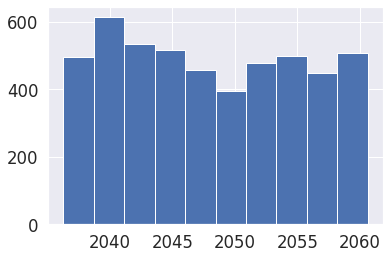

In [19]:
flc.fake_flares.tstart.hist()

In [110]:
flc.fake_flares.shape

(8372, 16)

Text(0, 0.5, 'ED recovered')

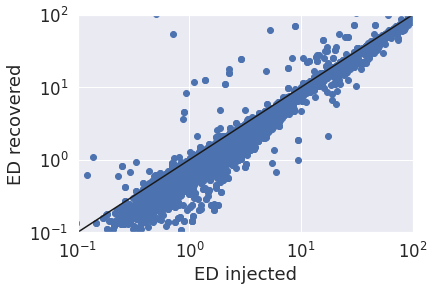

In [123]:
plt.scatter(flc.fake_flares.ed_inj,flc.fake_flares.ed_rec)
plt.plot([1e-1,100],[1e-1,100],c="k")
plt.xlim(1e-1,100)
plt.ylim(1e-1,100)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("ED injected")
plt.ylabel("ED recovered")

In [113]:
flc.fake_flares.columns

Index(['istart', 'istop', 'cstart', 'cstop', 'tstart', 'tstop', 'ed_rec',
       'ed_rec_err', 'duration_d', 'amplitude', 'ed_inj', 'peak_time',
       'ampl_rec', 'dur', 'total_n_valid_data_points', 'rec'],
      dtype='object')